In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_nlp

from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import TextVectorization, Input, Dense, Embedding, Dropout, GlobalAveragePooling1D, LSTM, Bidirectional, GlobalMaxPool1D, Flatten, Attention
from keras.metrics import Precision, Recall, AUC, SensitivityAtSpecificity, SpecificityAtSensitivity, F1Score


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve, f1_score, recall_score, roc_auc_score

class Config():
    def __init__(self):
        self.url = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/Filter_Toxic_Comments_dataset.csv"
        self.path = "/Users/simonebrazzi/datasets/toxic_comment/Filter_Toxic_Comments_dataset.csv"
        self.max_tokens = 20000
        self.output_sequence_length = 911 # check the analysis done to establish this value
        self.embedding_dim = 128
        self.batch_size = 32
        self.epochs = 100
        self.temp_split = 0.3
        self.test_split = 0.5
        self.random_state = 42
        self.total_samples = 159571 # total train samples
        self.train_samples = 111699
        self.val_samples = 23936
        self.features = 'comment_text'
        self.labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        self.new_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', "clean"]
        self.label_mapping = {label: i for i, label in enumerate(self.labels)}
        self.new_label_mapping = {label: i for i, label in enumerate(self.labels)}
        
        self.model = "model_f1.keras"
        self.checkpoint = "checkpoint.lstm_model_f1.keras"
        self.history = "lstm_model_f1.xlsx"
        self.matrix_file = "confusion_matrices.png"
        
        self.metrics = [
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc', multi_label=True, num_labels=len(self.labels)),
            F1Score(name="f1", average="macro")
            
        ]
    def get_early_stopping(self):
        early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_f1", # "val_recall",
            min_delta=0.2,
            patience=10,
            verbose=0,
            mode="max",
            restore_best_weights=True,
            start_from_epoch=3
        )
        return early_stopping

    def get_model_checkpoint(self, filepath):
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=filepath,
            monitor="val_f1", # "val_recall",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
            save_freq="epoch"
        )
        return model_checkpoint

    def find_optimal_threshold_cv(self, ytrue, yproba, metric, thresholds=np.arange(.05, .35, .05), n_splits=7):

      # instantiate KFold
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
      threshold_scores = []

      for threshold in thresholds:

        cv_scores = []
        for train_index, val_index in kf.split(ytrue):

          ytrue_val = ytrue[val_index]
          yproba_val = yproba[val_index]

          ypred_val = (yproba_val >= threshold).astype(int)
          score = metric(ytrue_val, ypred_val, average="macro")
          cv_scores.append(score)

        mean_score = np.mean(cv_scores)
        threshold_scores.append((threshold, mean_score))

        # Find the threshold with the highest mean score
        best_threshold, best_score = max(threshold_scores, key=lambda x: x[1])
      return best_threshold, best_score

config = Config()

In [2]:
file = tf.keras.utils.get_file("Filter_Toxic_Comments_dataset.csv", config.url)
df = pd.read_csv(file)
# df = pd.read_csv(config.path)
df.loc[df.sum_injurious == 0, "clean"] = 1
df.loc[df.sum_injurious != 0, "clean"] = 0

x = df[config.features].values
y = df[config.labels].values

xtrain, xtemp, ytrain, ytemp = train_test_split(
  x,
  y,
  test_size=config.temp_split, # .3
  random_state=config.random_state
  )
xtest, xval, ytest, yval = train_test_split(
  xtemp,
  ytemp,
  test_size=config.test_split, # .5
  random_state=config.random_state
  )

print(
    f"df shape: {df.shape[0]}\n",
  f"xtrain shape: {xtrain.shape}\n",
  f"ytrain shape: {ytrain.shape}\n",
  f"xtest shape: {xtest.shape}\n",
  f"ytest shape: {ytest.shape}\n",
  f"xval shape: {xval.shape}\n",
  f"yval shape: {yval.shape}\n"
  f"labels: {config.labels}\n"
  )

text_vectorization = TextVectorization(
  max_tokens=config.max_tokens,
  standardize="lower_and_strip_punctuation",
  split="whitespace",
  output_mode="int",
  output_sequence_length=config.output_sequence_length,
  pad_to_max_tokens=True
  )

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((xtrain, ytrain))
    .shuffle(xtrain.shape[0])
    .batch(config.batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset
    .from_tensor_slices((xtest, ytest))
    .batch(config.batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((xval, yval))
    .batch(config.batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Prepare a dataset that only yields raw text inputs (no labels)
text_train_ds = train_ds.map(lambda x, y: x)
# Adapt the text vectorization layer to the text data to index the dataset vocabulary
text_vectorization.adapt(text_train_ds)

processed_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
processed_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
processed_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

from keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

def get_deeper_lstm_model():
    clear_session()
    inputs = Input(shape=(None,), dtype=tf.int64, name="inputs")
    embedding = Embedding(
        input_dim=config.max_tokens,
        output_dim=config.embedding_dim,
        mask_zero=True,
        name="embedding"
    )(inputs)
    x = Bidirectional(LSTM(256, return_sequences=True, name="bilstm_1"))(embedding)
    x = Bidirectional(LSTM(128, return_sequences=True, name="bilstm_2"))(x)
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    # Add regularization
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LayerNormalization()(x)
    outputs = Dense(len(config.labels), activation='sigmoid', name="outputs")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=config.metrics, steps_per_execution=32)
    return model

model = get_deeper_lstm_model()

lab = pd.DataFrame(columns=config.labels, data=ytrain)
lab.shape

r = lab.sum() / len(ytrain)
class_weight = dict(zip(range(len(config.labels)), r))
class_weight

steps_per_epoch = config.train_samples // config.batch_size
validation_steps = config.val_samples // config.batch_size

# callbacks
my_es = config.get_early_stopping()
my_mc = config.get_model_checkpoint(filepath="/kaggle/working/"  + config.checkpoint)
callbacks = [my_es, my_mc]

66034407/66034407 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
df shape: 159571
 xtrain shape: (111699,)
 ytrain shape: (111699, 6)
 xtest shape: (23936,)
 ytest shape: (23936, 6)
 xval shape: (23936,)
 yval shape: (23936, 6)
labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']



In [3]:
history_deeper_lstm_model = model.fit(
    processed_train_ds.repeat(),
    epochs=config.epochs,
    validation_data=processed_val_ds.repeat(),
    callbacks=callbacks,
    class_weight=class_weight,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/100
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 390s 98ms/step - auc: 0.8880 - f1: 0.0441 - loss: 0.0575 - precision: 0.7018 - recall: 0.4701 - val_auc: 0.9494 - val_f1: 0.0293 - val_loss: 0.0641 - val_precision: 0.8939 - val_recall: 0.4625
Epoch 2/100
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 315s 90ms/step - auc: 0.9557 - f1: 0.0290 - loss: 0.0050 - precision: 0.7994 - recall: 0.6490 - val_auc: 0.9601 - val_f1: 0.0294 - val_loss: 0.0535 - val_precision: 0.7908 - val_recall: 0.6617
Epoch 3/100
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 315s 90ms/step - auc: 0.9672 - f1: 0.0291 - loss: 0.0044 - precision: 0.8166 - recall: 0.6815 - val_auc: 0.9633 - val_f1: 0.0295 - val_loss: 0.0544 - val_precision: 0.7733 - val_recall: 0.6961
Epoch 4/100
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 315s 90ms/step - auc: 0.9708 - f1: 0.0288 - loss: 0.0040 - precision: 0.8243 - recall: 0.7117 - val_auc: 0.9559 - val_f1: 0.0293 - val_loss: 0.0546 - val_precision: 0.7886 - val_recall: 0.6696
Epoch 5/100
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 315s 90ms/ste

In [6]:
model.save("/kaggle/working/" + config.model)
pd.DataFrame.from_dict(history_deeper_lstm_model.history).to_excel("/kaggle/working/" + config.history)

In [7]:
import keras
from keras.models import load_model

model = load_model(filepath="/kaggle/working/" + config.model)

history = pd.read_excel("/kaggle/working/" + config.history)

In [8]:
config.model, config.history

('model_f1.keras', 'lstm_model_f1.xlsx')

In [9]:
validation = model.evaluate(
  processed_val_ds.repeat(),
  steps=validation_steps, # 748
    verbose=1
  )

748/748 ━━━━━━━━━━━━━━━━━━━━ 87s 38ms/step - auc: 0.9542 - f1: 0.0287 - loss: 0.0529 - precision: 0.7858 - recall: 0.6763


In [10]:
predictions = model.predict(processed_test_ds, verbose=1)

748/748 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step


In [11]:
ytrue = ytest.astype(int)
y_pred_proba = predictions
optimal_threshold_recall, best_score_recall = config.find_optimal_threshold_cv(ytrue, y_pred_proba, recall_score)

# Use the optimal threshold to make predictions
final_predictions_recall = (y_pred_proba >= optimal_threshold_recall).astype(int)

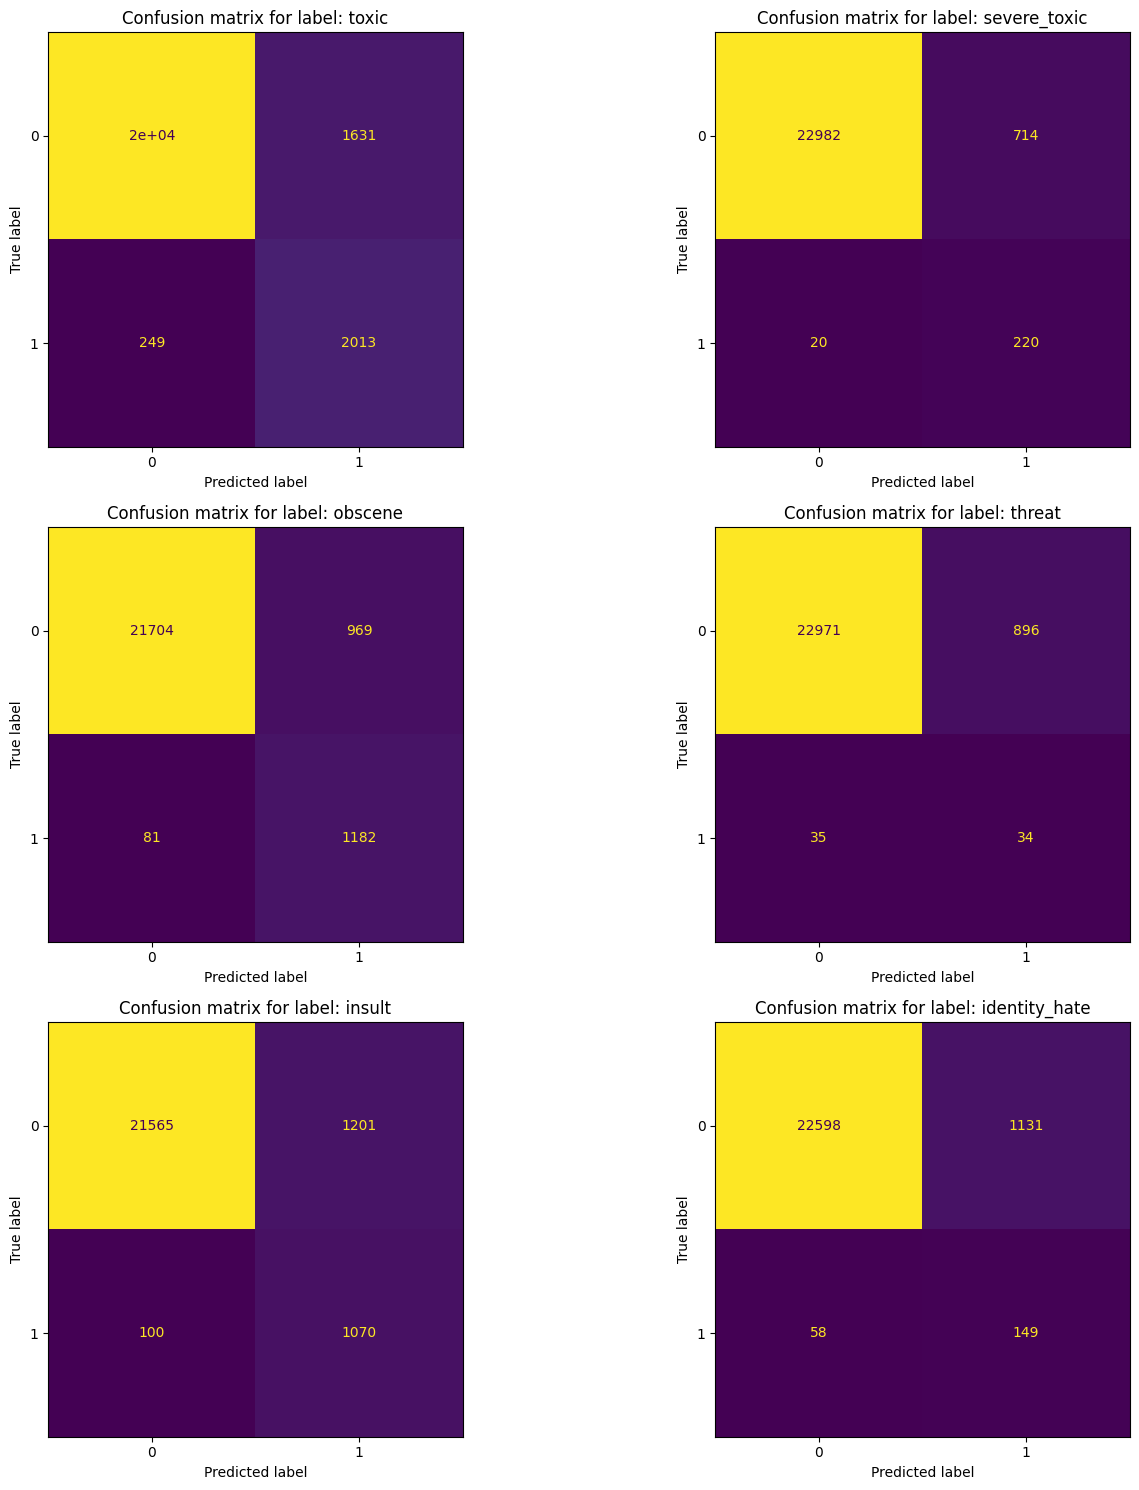

In [12]:
# convert probability predictions to predictions
ypred = predictions >=  optimal_threshold_recall # .05
ypred = ypred.astype(int)

# create a plot with 3 by 2 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
mcm = multilabel_confusion_matrix(ytrue, ypred)
# plot the confusion matrices for each label
for i, (cm, label) in enumerate(zip(mcm, config.labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"Confusion matrix for label: {label}")
plt.tight_layout()
plt.show()

In [13]:
cr = classification_report(
  ytrue,
  ypred,
  target_names=config.labels,
  digits=4
  )
print(cr)

               precision    recall  f1-score   support

        toxic     0.5524    0.8899    0.6817      2262
 severe_toxic     0.2355    0.9167    0.3748       240
      obscene     0.5495    0.9359    0.6924      1263
       threat     0.0366    0.4928    0.0681        69
       insult     0.4712    0.9145    0.6219      1170
identity_hate     0.1164    0.7198    0.2004       207

    micro avg     0.4164    0.8958    0.5685      5211
    macro avg     0.3269    0.8116    0.4399      5211
 weighted avg     0.4947    0.8958    0.6295      5211
  samples avg     0.0502    0.0848    0.0597      5211



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
